In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json

import cv2
import matplotlib.pyplot as plt

# import tensorflow
# import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

from tqdm import tqdm

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.metrics import fbeta_score
import time

Using TensorFlow backend.
/home/ubuntu/src/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
x_train = []
x_test = []
y_train = []
_BATCH_SIZE = 32
_EPOCH = 50
_IMG_SIZE = (64, 64)
_INPUT_SHAPE = (64, 64, 3)
_NUM_OF_CLASSES = 17
_NFOLDS = 5
_LABELS = [
    'haze',
    'artisinal_mine',
    'blooming',
    'habitation',
    'cultivation',
    'primary',
    'clear',
    'water',
    'road',
    'slash_burn',
    'cloudy',
    'agriculture',
    'partly_cloudy',
    'conventional_mine',
    'bare_ground',
    'selective_logging',
    'blow_down']
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/sample_submission.csv')


In [3]:
# df_train['tags'].values.shape
# flatten = lambda l: [item for sublist in l for item in sublist]
# labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))
labels = ['haze',
 'artisinal_mine',
 'blooming',
 'habitation',
 'cultivation',
 'primary',
 'clear',
 'water',
 'road',
 'slash_burn',
 'cloudy',
 'agriculture',
 'partly_cloudy',
 'conventional_mine',
 'bare_ground',
 'selective_logging',
 'blow_down']

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}
print(inv_label_map)

{0: 'haze', 1: 'artisinal_mine', 2: 'blooming', 3: 'habitation', 4: 'cultivation', 5: 'primary', 6: 'clear', 7: 'water', 8: 'road', 9: 'slash_burn', 10: 'cloudy', 11: 'agriculture', 12: 'partly_cloudy', 13: 'conventional_mine', 14: 'bare_ground', 15: 'selective_logging', 16: 'blow_down'}


In [ ]:
img = cv2.imread('../input/train-jpg/train_0.jpg')
img.shape

In [45]:
# Image preprocessing
from PIL import Image
def sharpen():
    _SHARP_KERNEL = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    for f, tags in tqdm(df_train.values[10000:], miniters=1000):
        img = cv2.imread('../input/train-jpg/{}.jpg'.format(f))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        sharpen_img = cv2.filter2D(img, -1, _SHARP_KERNEL)
        sharpen_img = Image.fromarray(np.uint8(sharpen_img))
        sharpen_img.save('../input/train-jpg-sharpen/{}.jpg'.format(f))
#         cv2.imwrite('../input/train-jpg-sharpen/{}.jpg'.format(f), sharpen_img, 100)
#         plt.subplot(121)
#         plt.imshow(img)
#         plt.subplot(122)
#         plt.imshow(sharpen_img)
#         plt.show()
def blur():
    pass

sharpen()

100%|██████████| 30479/30479 [02:07<00:00, 239.76it/s]


In [ ]:
for f, tags in tqdm(df_train.values[:10000], miniters=1000):
    img = cv2.imread('../input/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (64, 64)))
    y_train.append(targets)

for f, tags in tqdm(df_test.values[:10000], miniters=1000):
    img = cv2.imread('../input/test-jpg/{}.jpg'.format(f))
    x_test.append(cv2.resize(img, (64, 64)))
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32) / 255.
x_test  = np.array(x_test, np.float32) / 255.

print(x_train.shape)
print(y_train.shape)

In [ ]:
def load_model(weights_path=None):
    model = Sequential()

#     model.add(Conv2D(32, 3, 3, activation='relu', input_shape=(48, 48, 3)))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Conv2D(48, 3, 3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Conv2D(64, 3, 3, activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.25))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(17, activation='softmax'))

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=_INPUT_SHAPE))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(_NUM_OF_CLASSES))
    model.add(Activation('softmax'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    if weights_path:
        model.load_weights(weights_path)
    return model


In [ ]:
nfolds = 5

num_fold = 0
sum_score = 0

yfull_test = []
yfull_train =[]
historys = []
f_scores = [{}, {}, {}, {}, {}]

kf = KFold(len(y_train), n_folds=nfolds, shuffle=True, random_state=1)

for train_index, test_index in kf:
        start_time_model_fitting = time.time()
#         print(train_index, test_index)
        X_train = x_train[train_index]
        Y_train = y_train[train_index]
        X_valid = x_train[test_index]
        Y_valid = y_train[test_index]

        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, nfolds))
        print('Split train: ', len(X_train), len(Y_train))
        print('Split valid: ', len(X_valid), len(Y_valid))
        
        kfold_weights_path = os.path.join('', 'weights_kfold_' + str(num_fold) + '.h5')
        
#         model = load_model()

#         callbacks = [
#             EarlyStopping(monitor='val_loss', patience=2, verbose=0),
#             ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=0)]
        
#         history = model.fit(x = X_train, y= Y_train, validation_data=(X_valid, Y_valid),
#                   batch_size=32,verbose=2, epochs=50,callbacks=callbacks,
#                   shuffle=True)
#         historys.append(history)
        
        if os.path.isfile(kfold_weights_path):
            model = load_model(kfold_weights_path)
#             model.load_weights(kfold_weights_path)
        
        p_valid = model.predict(X_valid, batch_size = 128, verbose=2)
        for i in range(1, 10):
            threshold = (i + 1)/100.
            score = fbeta_score(Y_valid, np.array(p_valid) > threshold, beta=2, average='samples')
            f_scores[num_fold - 1][threshold] = score
        
#         p_test = model.predict(x_train, batch_size = 128, verbose=2)
#         yfull_train.append(p_test)
        
#         p_test = model.predict(x_test, batch_size = 128, verbose=2)
#         yfull_test.append(p_test)

In [44]:
thresholds = []
scores = 0

with open('fscore_1493796401.json') as f:
    f_scores = json.loads(f.read())
for score in f_scores[1:]:
    max_value = max(score, key=score.get)
    thresholds.append(max_value)
    scores += score[max_value]
print(scores/4.)

thresholds = []
scores = 0
with open('fscore_1493798113.json') as f:
    f_scores = json.loads(f.read())
for score in f_scores[1:]:
    max_value = max(score, key=score.get)
    thresholds.append(max_value)
    scores += score[max_value]
print(scores/4.)

0.8587029001101568
0.8549379555605944


In [34]:

with open('history_1493796401.json') as f:
    historys1 = json.loads(f.read())

with open('history_1493798113.json') as f:
    historys2 = json.loads(f.read())

plot_num = len(historys1)
for i in range(plot_num):
    history_dict1 = historys1[i]
    history_dict2 = historys2[i]
    # history_dict = history.history
#     loss_values = history_dict['loss']
    loss_values = history_dict1['val_loss']
    val_loss_values = history_dict2['val_loss']
    print(min(loss_values))
    print(min(val_loss_values))
    print('--------')
#     epochs = range(1, len(loss_values) + 1)
#     plt.subplot(plot_num, 1, i + 1)
#     # "bo" is for "blue dot"
#     plt.plot(epochs, np.array(loss_values), 'bo')
#     # b+ is for "blue crosses"
#     plt.plot(epochs, np.array(val_loss_values), 'b+')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')

#     plt.show()


0.3058786387443542
0.2912649050951004
--------
0.2908950395584106
0.2976260800361633
--------
0.29169939303398135
0.2930910124778748
--------
0.29763462114334105
0.2960721694231033
--------
0.28670839476585386
0.2903556272983551
--------


In [35]:
with open('fscore_1493796401.json') as f:
    scores = json.loads(f.read())
scores

[{'0.02': 0.822565380068371,
  '0.03': 0.8350924571903097,
  '0.04': 0.8401662519948249,
  '0.05': 0.8392753437663605,
  '0.06': 0.8339588480398324,
  '0.07': 0.8279548941686419,
  '0.08': 0.8187429633135713,
  '0.09': 0.8101804181692414,
  '0.1': 0.8013382606830417,
  '0.11': 0.7937314987180314,
  '0.12': 0.7856772302996353,
  '0.13': 0.7775785738503734,
  '0.14': 0.7661786425717634,
  '0.15': 0.7561575352681003},
 {'0.02': 0.8229874266167094,
  '0.03': 0.8399200369744582,
  '0.04': 0.8497989663438869,
  '0.05': 0.8590413683687559,
  '0.06': 0.8596388748280929,
  '0.07': 0.8592228768300358,
  '0.08': 0.8564787688388689,
  '0.09': 0.8542328667792346,
  '0.1': 0.8466678931052793,
  '0.11': 0.8409827396156722,
  '0.12': 0.83502535629003,
  '0.13': 0.8276645411205923,
  '0.14': 0.8187591883051255,
  '0.15': 0.8079915445661292},
 {'0.02': 0.8359250095757875,
  '0.03': 0.8492973946772417,
  '0.04': 0.8558994784675192,
  '0.05': 0.8587835711031394,
  '0.06': 0.8593758746412685,
  '0.07': 0.8

7 7
range(1, 8)


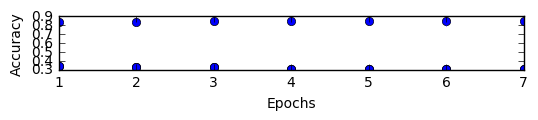

14 14
range(1, 15)


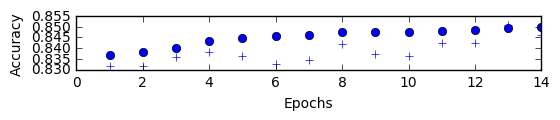

13 13
range(1, 14)


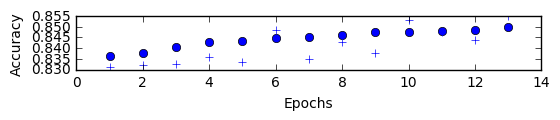

14 14
range(1, 15)


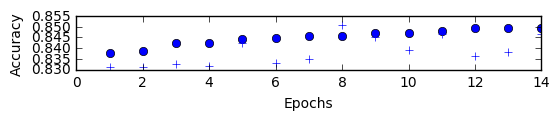

15 15
range(1, 16)


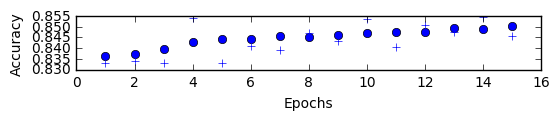

In [36]:
for i in range(plot_num):
    history_dict = historys1[i]
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    print(len(acc_values), len(val_acc_values))
    epochs = range(1, len(val_acc_values) + 1)
    print(epochs)
    plt.subplot(plot_num, 1, i+1)
    
    plt.plot(epochs, np.array(acc_values), 'bo')
    plt.plot(epochs, np.array(val_acc_values), 'b+')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

In [ ]:
yfull_test = []

for f, tags in tqdm(df_test.values, miniters=1000):
    img = cv2.imread('../input/test-jpg/{}.jpg'.format(f))
    x_test.append(cv2.resize(img, (64, 64)))

x_test  = np.array(x_test, np.float32) / 255.

In [ ]:
for i in range(1, 6):
    model = load_model('weights_kfold_' + str(i) + '.h5')
    p_test = model.predict(x_test, batch_size = 128, verbose=2)
    yfull_test.append(p_test)
    print('Finished {} prediction'.format(i))

In [ ]:
yfull_test[0].shape

In [ ]:
binary_results = []
for i in range(_NFOLDS):
    result = np.array(yfull_test[i])
    result = np.where(result > float(thresholds[i]), 1, 0)
    binary_results.append(result)

final_result = binary_results[0]
for i in range(1, _NFOLDS):
    final_result += binary_results[i]
# final_result = pd.DataFrame(result, columns = labels)
final_result = np.where(final_result > 2., 1, 0)
# final_result[:10]
# result = np.array(yfull_test[0])
# for i in range(1, _NFOLDS):
#     result += np.array(yfull_test[i])
# result /= _NFOLDS
result = pd.DataFrame(final_result, columns = labels)
result

In [ ]:
result.shape

In [ ]:
preds = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > 0, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

In [ ]:
# preds
df_test['tags'] = preds
df_test

In [ ]:
df_test.to_csv('submission_keras2.csv', index=False)